In [261]:
import torch
from torch import nn
import math

# Attention is all you need

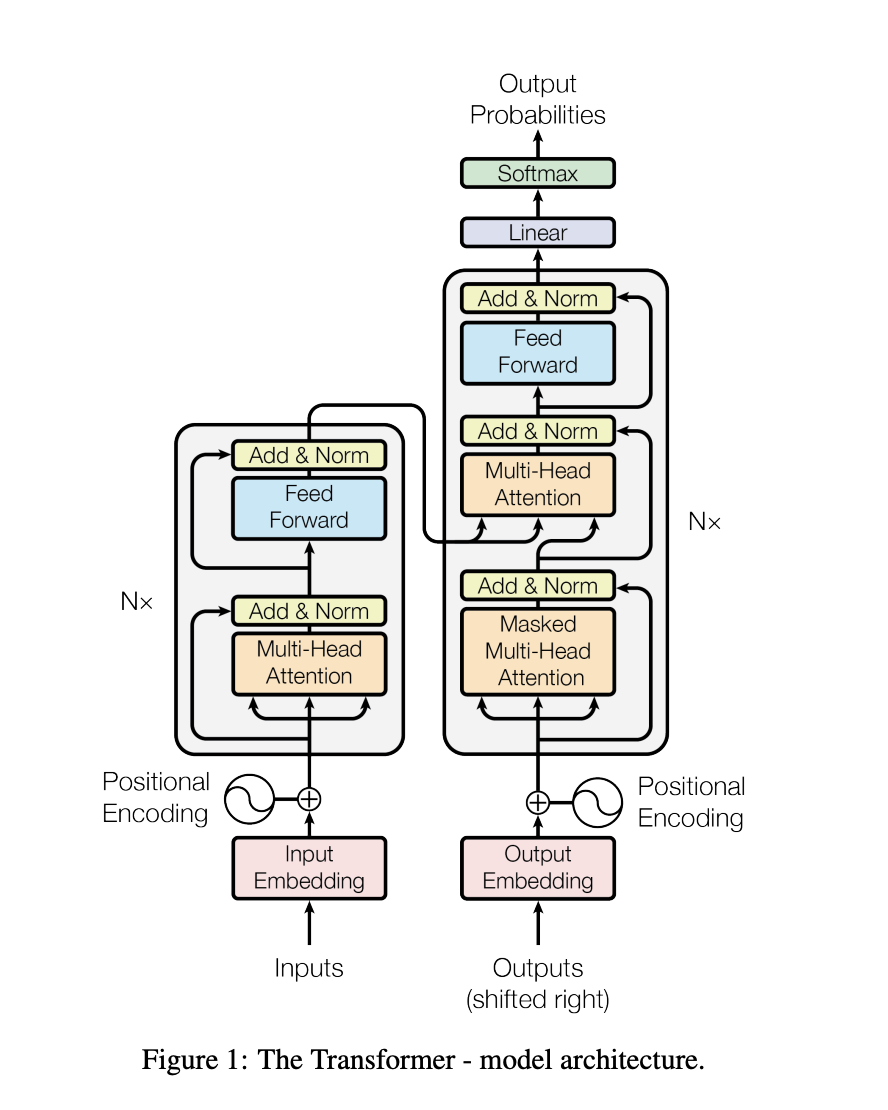

# Parameters and descriptions

- Vocab Size: all the tokens that can be part of the input sequence. sequences are tokenized based on the vocab
- Sequence Length: this is the length of the sentence or sequence fed into the tranformer
- Embedding Size: this is the size of the embedding for each node in the sequence above

S X E dimension for one sequence (S = d_model in the paper)

B X S X E for a batch size of B

From paper:

> To facilitate these residual connections, all sub-layers in the model, as well as the embedding
layers, produce outputs of dimension dmodel = 512.

- Number of Heads: Number of heads in the attenion layer
- Head dimension: Can be calculated from embedding dimension and number of heads: embedding_size // num_heads (this is the same as d_k in the paper)


From paper:

> We call our particular attention "Scaled Dot-Product Attention" (Figure 2). The input consists of
queries and keys of dimension d_k, and values of dimension d_v

Attention

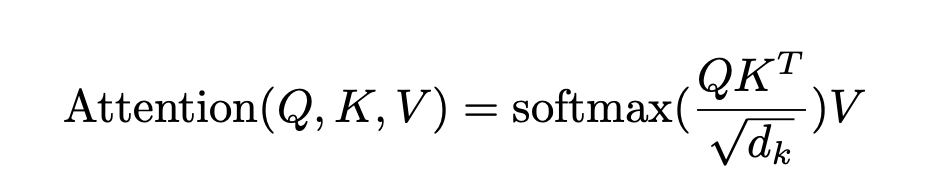

- Dropout: dropout rate after attention layer
- Feed Forward Hidden size: Hidden dimension for feed forward layer

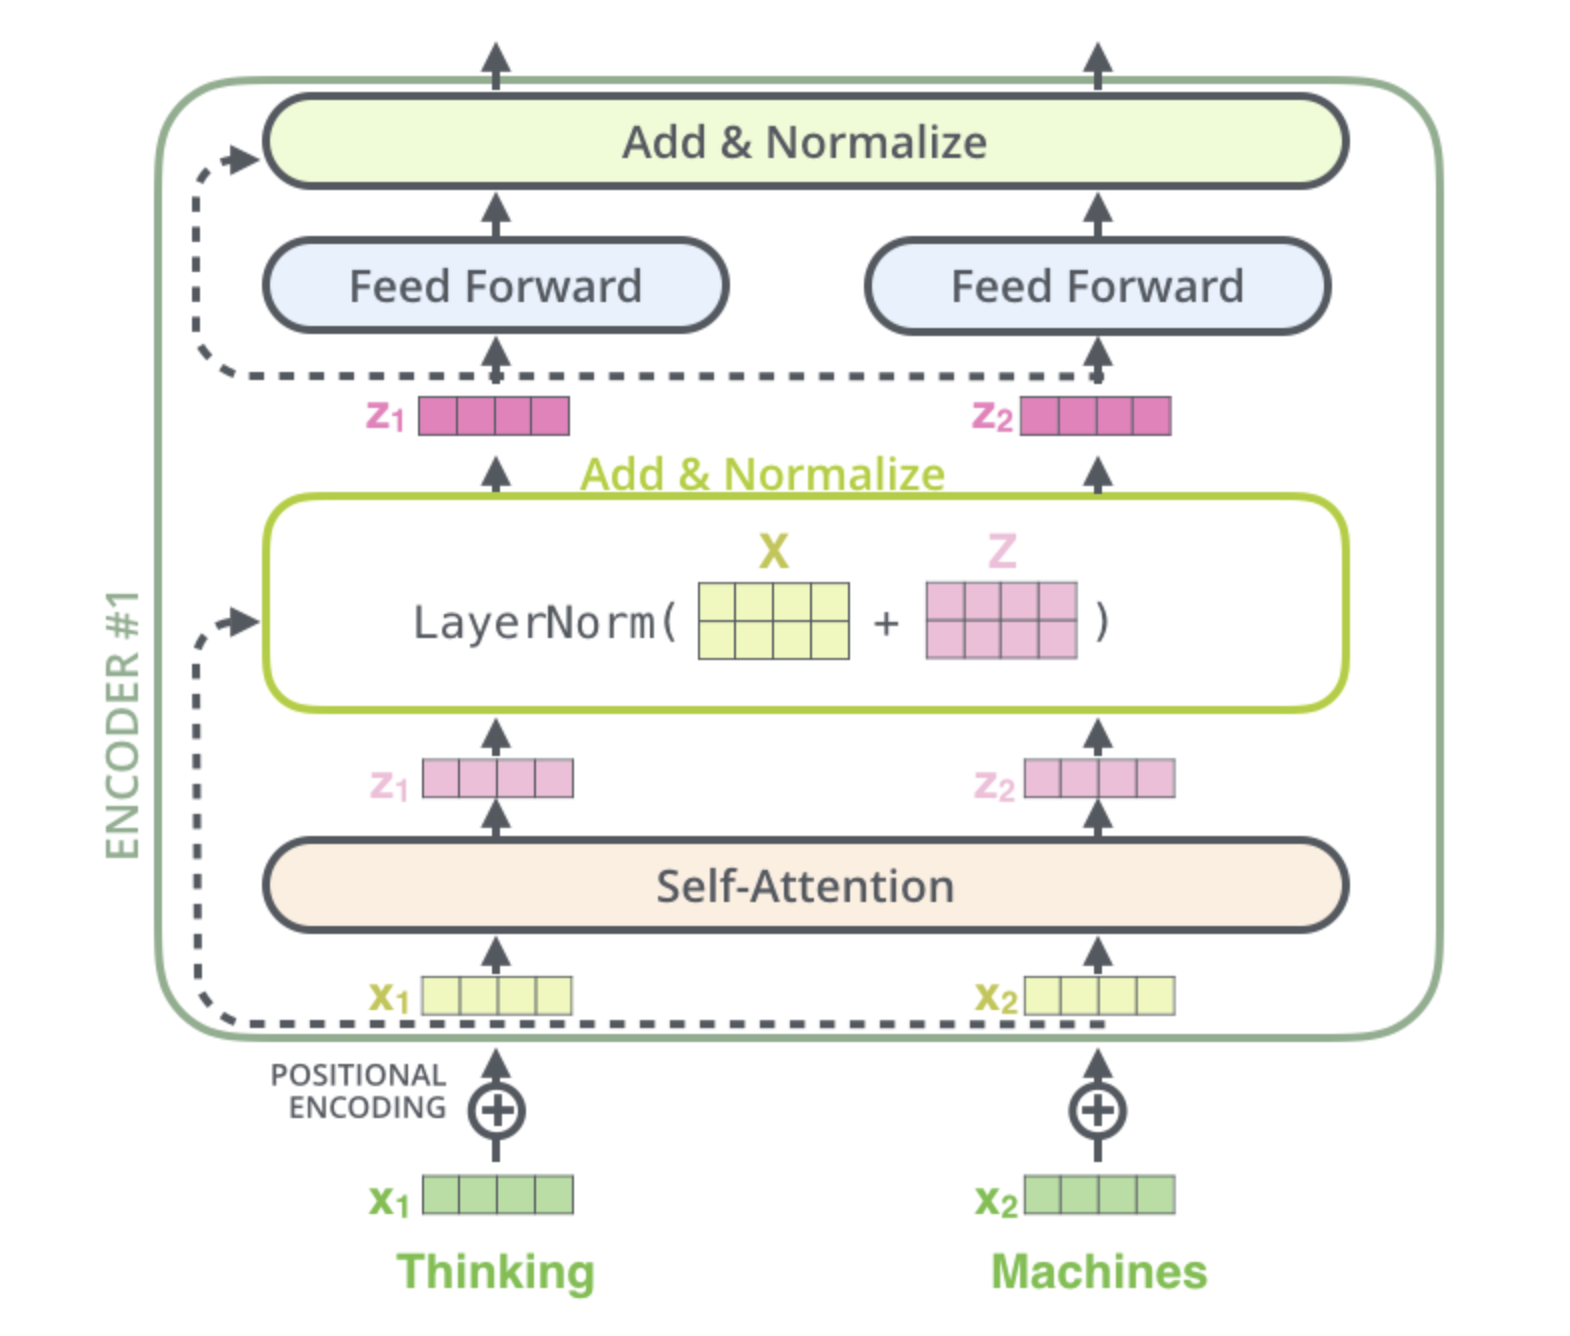

# Encoder

- Input -> Sparse Embedding
- X = Sparse Embedding + Position Embedding
- Calculate A_out = MultiHeadAttn(X)
- A_out = Dropout(A_out)
- L_out = LayerNorm(A_out + X)
- F_out = FeedForwardNN(L_out)
- F_out = Dropout(F_out)
- out = LayerNorm(F_out + L_out)

In [166]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('gpt2')

# Read the novel from the text file
with open('./data/1984.txt', 'r', encoding='utf-8') as file:
    novel_text = file.read()

In [167]:
encoded_input = tokenizer(novel_text, return_tensors='pt')
encoded_input

Token indices sequence length is longer than the specified maximum sequence length for this model (141170 > 1024). Running this sequence through the model will result in indexing errors


{'input_ids': tensor([[14126,   352,   628,  ..., 10970, 23578,   198]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]])}

In [168]:
sequence_length = 10

In [169]:
model_inputs = encoded_input["input_ids"].ravel().unfold(0, sequence_length, 1).to(torch.int32)

In [170]:
model_inputs

tensor([[14126,   352,   628,  ...,   257,  6016,  4692],
        [  352,   628,   198,  ...,  6016,  4692,  1110],
        [  628,   198,   198,  ...,  4692,  1110,   287],
        ...,
        [ 2739,   257,  3128,  ...,   198,   198, 10970],
        [  257,  3128,   355,  ...,   198, 10970, 23578],
        [ 3128,   355, 32215,  ..., 10970, 23578,   198]], dtype=torch.int32)

In [171]:
batch = model_inputs[:4, :]

In [172]:
batch

tensor([[14126,   352,   628,   198,   198,  1026,   373,   257,  6016,  4692],
        [  352,   628,   198,   198,  1026,   373,   257,  6016,  4692,  1110],
        [  628,   198,   198,  1026,   373,   257,  6016,  4692,  1110,   287],
        [  198,   198,  1026,   373,   257,  6016,  4692,  1110,   287,  3035]],
       dtype=torch.int32)

# Position Encoding

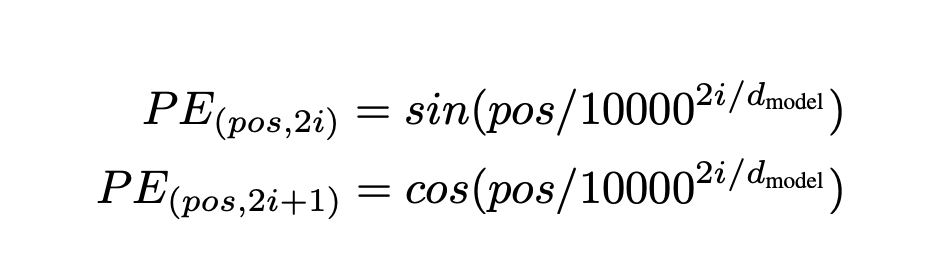

In [173]:
embedding_dimension = 6 # d_model

In [174]:
even_index = torch.arange(0, embedding_dimension, 2)
odd_index = torch.arange(1, embedding_dimension, 2)

In [175]:
even_index

tensor([0, 2, 4])

In [176]:
odd_index

tensor([1, 3, 5])

In [177]:
denominator = torch.pow(10000, even_index / embedding_dimension)
denominator # odd denominator is the same

tensor([  1.0000,  21.5443, 464.1590])

In [178]:
positions = torch.arange(0, sequence_length, 1).reshape(sequence_length, 1)
positions

tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]])

In [179]:
even_pe = torch.sin(positions / denominator)
odd_pe = torch.cos(positions / denominator)

In [180]:
even_pe

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.0464,  0.0022],
        [ 0.9093,  0.0927,  0.0043],
        [ 0.1411,  0.1388,  0.0065],
        [-0.7568,  0.1846,  0.0086],
        [-0.9589,  0.2300,  0.0108],
        [-0.2794,  0.2749,  0.0129],
        [ 0.6570,  0.3192,  0.0151],
        [ 0.9894,  0.3629,  0.0172],
        [ 0.4121,  0.4057,  0.0194]])

In [181]:
odd_pe

tensor([[ 1.0000,  1.0000,  1.0000],
        [ 0.5403,  0.9989,  1.0000],
        [-0.4161,  0.9957,  1.0000],
        [-0.9900,  0.9903,  1.0000],
        [-0.6536,  0.9828,  1.0000],
        [ 0.2837,  0.9732,  0.9999],
        [ 0.9602,  0.9615,  0.9999],
        [ 0.7539,  0.9477,  0.9999],
        [-0.1455,  0.9318,  0.9999],
        [-0.9111,  0.9140,  0.9998]])

In [182]:
stacked = torch.stack([even_pe, odd_pe], dim=2)
position_embeddings = torch.flatten(stacked, start_dim=1, end_dim=2)

In [183]:
position_embeddings

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998]])

50257

# Input Layer

In [221]:
class InputLayer(nn.Module):
    def __init__(self, 
                 num_embeddings: int, 
                 sequence_length: int, 
                 embedding_dimension: int):
        super().__init__()
        self.sequence_length = sequence_length
        self.embedding_dimension = embedding_dimension
        self.input_embeddings = nn.Embedding(num_embeddings=num_embeddings, 
                                             embedding_dim=embedding_dimension)
        self.position_embeddings = self._init_position_embedding(sequence_length, embedding_dimension)
        print(sequence_length, embedding_dimension)

    @staticmethod
    def _init_position_embedding(sl: int, ed: int) -> torch.Tensor:
        even_index = torch.arange(0, embedding_dimension, 2)
        odd_index = torch.arange(1, embedding_dimension, 2)
        denominator = torch.pow(10000, even_index / embedding_dimension)
        even_pe = torch.sin(positions / denominator)
        odd_pe = torch.cos(positions / denominator)
        stacked = torch.stack([even_pe, odd_pe], dim=2)
        return torch.flatten(stacked, start_dim=1, end_dim=2)
        
    
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        emb = self.input_embeddings(input)
        return emb + self.position_embeddings

In [222]:
input_layer = InputLayer(num_embeddings=len(tokenizer.get_vocab()), sequence_length=sequence_length, embedding_dimension=embedding_dimension)

10 6


In [223]:
input_layer

InputLayer(
  (input_embeddings): Embedding(50257, 6)
)

In [225]:
attention_input = input_layer(batch)

In [226]:
attention_input.size()

torch.Size([4, 10, 6])

In [228]:
attention_input

tensor([[[-1.0026,  1.3379,  1.2306,  2.0714,  0.9880,  0.6263],
         [ 0.6907, -0.1317,  0.0784,  0.5511, -0.2271,  1.7377],
         [-1.7402, -0.8255,  0.2493,  1.8052, -0.7956,  1.0679],
         [ 1.9075, -1.4238, -0.1602,  0.6514,  0.8709,  1.4486],
         [ 1.0096, -1.0874, -0.1144,  0.6439,  0.8730,  1.4485],
         [-0.2123,  0.3724,  1.1337,  1.9448,  0.4954,  0.6982],
         [-0.5270,  1.1866, -0.2247, -0.0603,  0.4675,  1.3287],
         [-0.3475, -0.1834,  1.8020,  1.8148,  1.8469, -0.3561],
         [ 1.5308,  0.9004,  0.1371,  0.3954, -1.1751,  1.3899],
         [-0.4226, -1.8622,  0.3760, -2.0101,  0.4897,  0.8752]],

        [[-0.1508,  0.3280,  0.0320,  0.5522, -0.2293,  1.7377],
         [-1.8081,  0.1310,  0.2030,  1.8085, -0.7978,  1.0679],
         [ 2.6757, -0.8499, -0.2063,  0.6568,  0.8687,  1.4486],
         [ 1.9075, -1.4238, -0.1602,  0.6514,  0.8709,  1.4486],
         [-0.0102, -0.5649,  1.0883,  1.9544,  0.4932,  0.6982],
         [-1.2065,  0.5

# Multi Head Attention

In [220]:
num_heads = 2
head_dimension = embedding_dimension // num_heads
if embedding_dimension % num_heads != 0:
    raise ValueError("embedding_dimension should be divisible by num_heads")

In [243]:
# split up input into Q, K, V
qkv_layer = nn.Linear(embedding_dimension, 3 * embedding_dimension)
with torch.no_grad():
    qkv_layer.weight.fill_(2)

qkv = qkv_layer(attention_input)

In [244]:
qkv.size()

torch.Size([4, 10, 18])

In [245]:
input_shape = attention_input.shape
input_shape = input_shape[:-1] + (num_heads, 3 * head_dimension)
input_shape

torch.Size([4, 10, 2, 9])

In [246]:
qkv = qkv.reshape(*input_shape)
qkv = qkv.permute(0, 2, 1, 3)

In [249]:
qkv.size() # batch_size, num_head, sequence_length, 3 * head_dim

torch.Size([4, 2, 10, 9])

In [250]:
q, k, v = qkv.chunk(3, dim=-1)

In [257]:
for masked in [True, False]:
    if masked:
        mask = torch.full((sequence_length, sequence_length),
                          -torch.inf)
        mask = torch.triu(mask, diagonal=1)
    else:
        mask = torch.zeros((sequence_length, sequence_length))
    print(mask)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [

## Scaled Dot Product Attention

In [318]:
scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(head_dimension)
scores += mask
attention = torch.softmax(scores, dim=-1)       

In [319]:
attention.size()

torch.Size([4, 2, 10, 10])

In [320]:
values = torch.matmul(attention, v)

In [321]:
values.size()

torch.Size([4, 2, 10, 3])

In [322]:
values_out = values.permute(0, 2, 1, 3)

In [323]:
values_shape = values_out.shape

In [324]:
values_out = values_out.reshape(*values_shape[:-2], -1)

In [325]:
values_out.shape

torch.Size([4, 10, 6])

In [326]:
attn_linear_layer = nn.Linear(embedding_dimension, embedding_dimension)

In [327]:
attn_out = attn_linear_layer(values_out)

In [328]:
attn_out

tensor([[[-3.0562, -1.7735,  3.2937,  4.9568, -8.2007, -2.7426],
         [-3.0562, -1.7735,  3.2937,  4.9568, -8.2007, -2.7426],
         [ 1.8961,  0.4495, -2.2199, -1.5558,  4.3723,  1.2748],
         [-3.0562, -1.7735,  3.2937,  4.9568, -8.2007, -2.7426],
         [-3.0562, -1.7735,  3.2937,  4.9568, -8.2007, -2.7426],
         [-3.0562, -1.7735,  3.2937,  4.9568, -8.2007, -2.7426],
         [-3.0562, -1.7735,  3.2937,  4.9567, -8.2006, -2.7425],
         [-3.0562, -1.7735,  3.2937,  4.9568, -8.2007, -2.7426],
         [-3.0562, -1.7735,  3.2937,  4.9568, -8.2007, -2.7426],
         [ 1.9981,  0.4145, -2.1703, -1.5568,  4.4600,  1.1755]],

        [[-2.6300, -1.5890,  2.8330,  4.4075, -7.1331, -2.4122],
         [-2.6893, -1.4638,  2.5926,  4.2354, -6.9620, -2.1185],
         [-2.6300, -1.5890,  2.8330,  4.4075, -7.1331, -2.4122],
         [-2.6300, -1.5890,  2.8330,  4.4075, -7.1331, -2.4122],
         [-2.6300, -1.5890,  2.8330,  4.4075, -7.1331, -2.4122],
         [-2.6562, -1.5